In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from sklearn.model_selection import train_test_split
from keras.models import load_model

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
submit = pd.read_csv('../input/test.csv')


In [3]:
X_train, X_test, y_train, y_test = train_test_split(train, train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]], test_size = 0.10, random_state = 42)

In [4]:
list_sentences_train = X_train["comment_text"]
list_sentences_test = X_test["comment_text"]
list_sentences_submit = submit["comment_text"]

In [5]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features,char_level=True)

In [6]:
tokenizer.fit_on_texts(list(list_sentences_train))


In [7]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_sentences_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_submit = tokenizer.texts_to_sequences(list_sentences_submit)

In [8]:
maxlen = 500
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_sentences_test, maxlen=maxlen)
X_sub = pad_sequences(list_tokenized_submit, maxlen=maxlen)

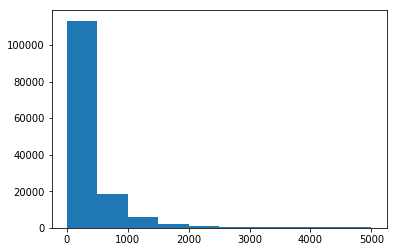

In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords)
plt.show()

In [10]:
inp = Input(shape=(maxlen, ))

embed_size = 240
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)

x = Conv1D(filters=100,kernel_size=4,padding='same', activation='relu')(x)

x=MaxPooling1D(pool_size=4)(x)

x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)

x = GlobalMaxPool1D()(x)

x = Dense(50, activation="relu")(x)

x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 240)          492480    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 100)          96100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 125, 120)          57960     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6050      
__________

In [11]:
batch_size = 32
epochs = 1
hist = model.fit(X_t,y_train, batch_size=batch_size, epochs=epochs,validation_data=(X_te,y_test))

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
143613/143613 [==============================] - 1751s 12ms/step - loss: 0.0777 - acc: 0.9764 - val_loss: 0.0550 - val_acc: 0.9812


In [12]:
def toxicity_level(string):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=500, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('hola, como estas')
toxicity_level('hola mierda joder')
toxicity_level('fuck off!!')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         86%
Severe Toxic:  19%
Obscene:       64%
Threat:        8%
Insult:        44%
Identity Hate: 20%

Toxicity levels for 'i will kill you':
Toxic:         54%
Severe Toxic:  3%
Obscene:       12%
Threat:        8%
Insult:        23%
Identity Hate: 6%

Toxicity levels for 'have a nice day':
Toxic:         26%
Severe Toxic:  1%
Obscene:       10%
Threat:        2%
Insult:        10%
Identity Hate: 4%

Toxicity levels for 'hola, como estas':
Toxic:         18%
Severe Toxic:  1%
Obscene:       6%
Threat:        2%
Insult:        7%
Identity Hate: 2%

Toxicity levels for 'hola mierda joder':
Toxic:         31%
Severe Toxic:  2%
Obscene:       9%
Threat:        3%
Insult:        12%
Identity Hate: 4%

Toxicity levels for 'fuck off!!':
Toxic:         100%
Severe Toxic:  45%
Obscene:       98%
Threat:        1%
Insult:        77%
Identity Hate: 16%



In [13]:
def print_metrics(accuracy):
    print("Simple cnn model performance")
    print('Accuracy: ', np.round(accuracy, 4))
    print('\n')
    
loss, accuracy = model.evaluate(X_t, y_train)
print_metrics(accuracy)

143613/143613 [==============================] - 614s 4ms/step
Simple cnn model performance
Accuracy:  0.9811


